# Hub'Eau time series univariate forecasting

Setup our working environment first in order to be able to display some data and make training/prediction:

In [9]:
import tensorflow as tf
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False
tf.random.set_seed(13)

Then read data from a station and display it:

array([<matplotlib.axes._subplots.AxesSubplot object at 0x0000018DF02FE688>],
      dtype=object)

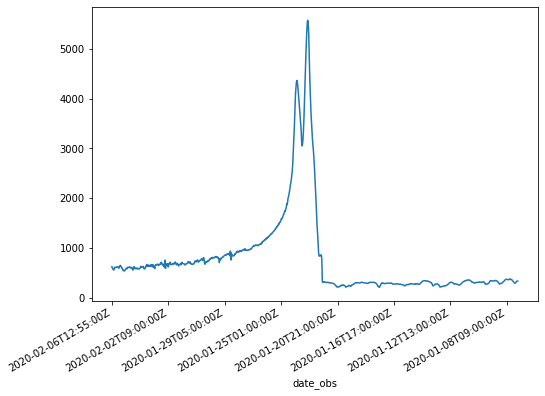

In [24]:
raw = pd.read_csv("hubeau_site_Y1422030_30d_30m_L'Aude.csv", delimiter=';')
data = raw['resultat_obs']
data.index = raw['date_obs']
data.head()
data.plot(subplots=True)

We will work with two setups:
* a single step setup where the model learns to predict a single point in the future based on some history provided
* a multi-step setup where given a past history the model needs to learn to predict a range of future values 

Let's say you want to predict the water level 6 hours in the future. In order to make this prediction, you choose to use 5 days of observations. Thus, you would create a window containing the last 240 (5x48) observations to train the model if your time step is 30 minutes (2 observations per hour). Many such configurations are possible, making this dataset a good one to experiment with.

The function below returns the above described windows of time for the model to train on. The parameter `history_size` is the size of the past window of information. The `target_size` is how far in the future does the model need to learn to predict, ie the label(s) that needs to be predicted.


In [47]:
def data_windows(dataset, start_index, end_index, history_size, target_size, single_step=False):
  data = []
  labels = []

  start_index = start_index + history_size
  if end_index is None:
    end_index = len(dataset) - target_size

  for i in range(start_index, end_index):
    indices = range(i-history_size, i)
    # Reshape data from (history_size,) to (history_size, 1)
    data.append(np.reshape(dataset[indices], (history_size, 1)))
    if single_step:
      labels.append(dataset[i+target_size])
    else:
      labels.append(dataset[i:i+target_size])
    
  return np.array(data), np.array(labels)

Let's keep 75% of data to train (remaining will be the validation dataset) and standardize the data:

In [48]:
train_split = round(data.size * 0.75)
print('Training dataset length is {} for total data length {}'.format(train_split, data.size))
mean = data.values[:train_split].mean()
std = data.values[:train_split].std()
print ('Training Mean value {} - Std value {}'.format(mean, std))
ndata = (data.values-mean)/std

Training dataset length is 1080 for total data length 1440
Training Mean value 918.262962962963 - Std value 953.6654730848674


We first start with the single step setup: the model learns to predict a single point in the future based on some history provided. Let's now create the data for the model, it will be given the last 48 recorded observations (ie 24H if your time step is 30 minutes), and needs to learn to predict the level in 2H (ie 4 observations ahead if your time step is 30 minutes).

Sample window [[-0.31380287]
 [-0.333726  ]
 [-0.34945479]
 [-0.35784347]
 [-0.36623216]
 [-0.3777666 ]
 [-0.38300953]
 [-0.38196094]
 [-0.36728074]
 [-0.33477458]
 [-0.32324014]
 [-0.32743448]
 [-0.32743448]
 [-0.33162883]
 [-0.33162883]
 [-0.33162883]
 [-0.32428873]
 [-0.32324014]
 [-0.31694863]
 [-0.31485146]
 [-0.31485146]
 [-0.31485146]
 [-0.32428873]
 [-0.32953166]
 [-0.3410661 ]
 [-0.34421186]
 [-0.32428873]
 [-0.30226843]
 [-0.3043656 ]
 [-0.29807408]
 [-0.28653964]
 [-0.30017126]
 [-0.30017126]
 [-0.3190458 ]
 [-0.33058024]
 [-0.34316327]
 [-0.34316327]
 [-0.34526044]
 [-0.37462084]
 [-0.38300953]
 [-0.39349539]
 [-0.39034963]
 [-0.39559256]
 [-0.40083549]
 [-0.40293266]
 [-0.39559256]
 [-0.39349539]
 [-0.37986377]]
Target level value -0.3484061993858036


<module 'matplotlib.pyplot' from 'D:\\Applications\\Anaconda3\\envs\\tf-gpu\\lib\\site-packages\\matplotlib\\pyplot.py'>

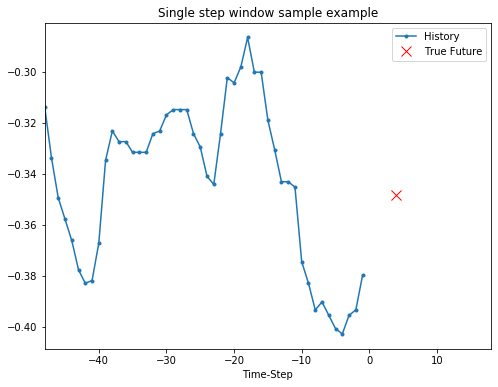

In [49]:
history = 48
future = 4

x_train, y_train = data_windows(ndata, 0, train_split, history, future, single_step=True)
x_validate, y_validate = data_windows(ndata, train_split, None, history, future, single_step=True)

print ('Sample window {}'.format(x_train[0]))
print ('Target level value {}'.format(y_train[0]))

def show_single_plot(plot_data, delta, title):
  labels = ['History', 'True Future', 'Model Prediction']
  marker = ['.-', 'rx', 'go']
  time_steps = list(range(-plot_data[0].shape[0], 0))
  if delta:
    future = delta
  else:
    future = 0

  plt.title(title)
  for i, x in enumerate(plot_data):
    if i:
      plt.plot(future, plot_data[i], marker[i], markersize=10,
               label=labels[i])
    else:
      plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
  plt.legend()
  plt.xlim([time_steps[0], (future+5)*2])
  plt.xlabel('Time-Step')
  return plt

show_single_plot([x_train[0], y_train[0]], future, 'Single step window sample example')

A Recurrent Neural Network (RNN) is a type of neural network well-suited to time series data. RNNs process a time series step-by-step, maintaining an internal state summarizing the information they've seen so far. In this experiment, we will use a specialized RNN layer called Long Short Term Memory (LSTM):

Train for 200 steps, validate for 50 steps
Epoch 1/10
200/200 [==============================] - 4s 22ms/step - loss: 0.1860 - val_loss: 0.0233
Epoch 2/10
200/200 [==============================] - 2s 9ms/step - loss: 0.0978 - val_loss: 0.0243
Epoch 3/10
200/200 [==============================] - 2s 9ms/step - loss: 0.0807 - val_loss: 0.0241
Epoch 4/10
200/200 [==============================] - 2s 9ms/step - loss: 0.0621 - val_loss: 0.0256
Epoch 5/10
200/200 [==============================] - 2s 9ms/step - loss: 0.0377 - val_loss: 0.0265
Epoch 6/10
200/200 [==============================] - 2s 9ms/step - loss: 0.0343 - val_loss: 0.0244
Epoch 7/10
200/200 [==============================] - 2s 9ms/step - loss: 0.0279 - val_loss: 0.0257
Epoch 8/10
200/200 [==============================] - 2s 9ms/step - loss: 0.0255 - val_loss: 0.0249
Epoch 9/10
200/200 [==============================] - 2s 9ms/step - loss: 0.0244 - val_loss: 0.0247
Epoch 10/10
200/200 [==============================] - 2

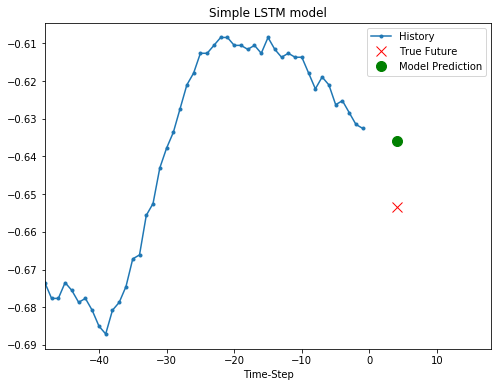

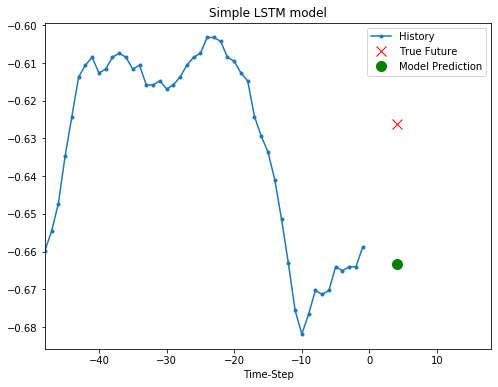

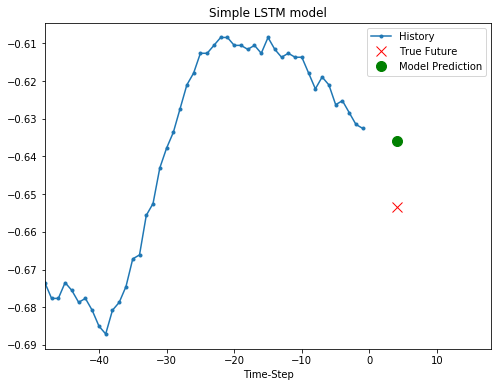

In [50]:
batch_size = 256
buffer_size = 10000

train = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train = train.cache().shuffle(buffer_size).batch(batch_size).repeat()

validate = tf.data.Dataset.from_tensor_slices((x_validate, y_validate))
validate = validate.batch(batch_size).repeat()

simple_lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(8, input_shape=x_train.shape[-2:]),
    tf.keras.layers.Dense(1)
])

simple_lstm_model.compile(optimizer='adam', loss='mae')

simple_lstm_model.fit(train, epochs=10,
                      steps_per_epoch=200,
                      validation_data=validate, validation_steps=50)

for x, y in validate.take(3):
  plot = show_single_plot([x[0].numpy(), y[0].numpy(),
                          simple_lstm_model.predict(x)[0]], future, 'Simple LSTM model')
  plot.show()

We will then work with the multi-step setup, ie given a past history, the model needs to learn to predict a range of future values. Data setup and model training is pretty similar except since the task here is a bit more complicated than the previous task, the model now consists of two LSTM layers.

Sample window [[-0.31380287]
 [-0.333726  ]
 [-0.34945479]
 [-0.35784347]
 [-0.36623216]
 [-0.3777666 ]
 [-0.38300953]
 [-0.38196094]
 [-0.36728074]
 [-0.33477458]
 [-0.32324014]
 [-0.32743448]
 [-0.32743448]
 [-0.33162883]
 [-0.33162883]
 [-0.33162883]
 [-0.32428873]
 [-0.32324014]
 [-0.31694863]
 [-0.31485146]
 [-0.31485146]
 [-0.31485146]
 [-0.32428873]
 [-0.32953166]
 [-0.3410661 ]
 [-0.34421186]
 [-0.32428873]
 [-0.30226843]
 [-0.3043656 ]
 [-0.29807408]
 [-0.28653964]
 [-0.30017126]
 [-0.30017126]
 [-0.3190458 ]
 [-0.33058024]
 [-0.34316327]
 [-0.34316327]
 [-0.34526044]
 [-0.37462084]
 [-0.38300953]
 [-0.39349539]
 [-0.39034963]
 [-0.39559256]
 [-0.40083549]
 [-0.40293266]
 [-0.39559256]
 [-0.39349539]
 [-0.37986377]]
Target level values [-0.37147509 -0.36413499 -0.35260054 -0.34735761 -0.3484062  -0.35784347
 -0.35260054 -0.33896893]


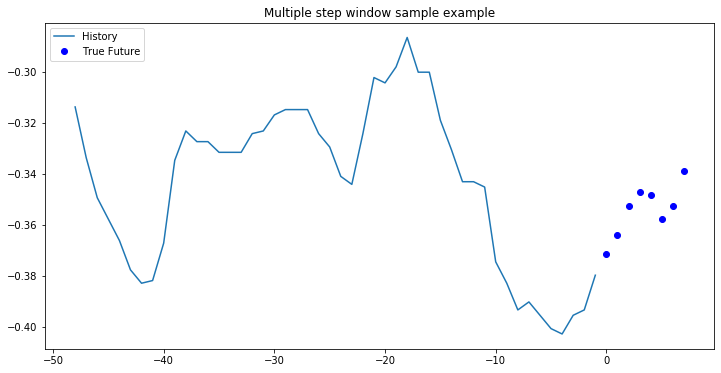

Train for 200 steps, validate for 50 steps
Epoch 1/10
200/200 [==============================] - 20s 99ms/step - loss: 0.2679 - val_loss: 0.0458
Epoch 2/10
200/200 [==============================] - 15s 76ms/step - loss: 0.0808 - val_loss: 0.0382
Epoch 3/10
200/200 [==============================] - 15s 76ms/step - loss: 0.0605 - val_loss: 0.0331
Epoch 4/10
200/200 [==============================] - 15s 76ms/step - loss: 0.0565 - val_loss: 0.0463
Epoch 5/10
200/200 [==============================] - 15s 77ms/step - loss: 0.0498 - val_loss: 0.0288
Epoch 6/10
200/200 [==============================] - 16s 78ms/step - loss: 0.0433 - val_loss: 0.0271
Epoch 7/10
200/200 [==============================] - 15s 77ms/step - loss: 0.0379 - val_loss: 0.0255
Epoch 8/10
200/200 [==============================] - 15s 76ms/step - loss: 0.0347 - val_loss: 0.0267
Epoch 9/10
200/200 [==============================] - 15s 77ms/step - loss: 0.0335 - val_loss: 0.0295
Epoch 10/10
200/200 [==================

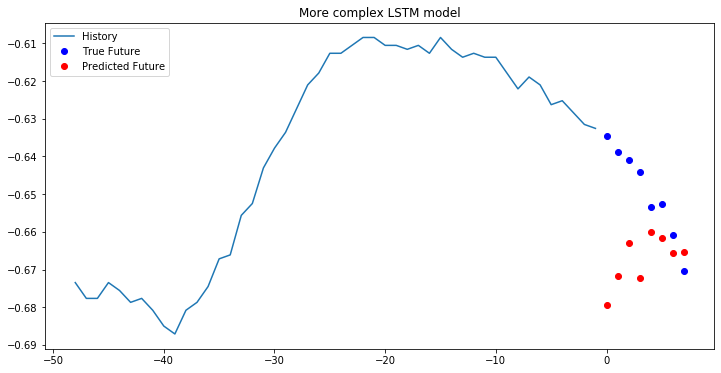

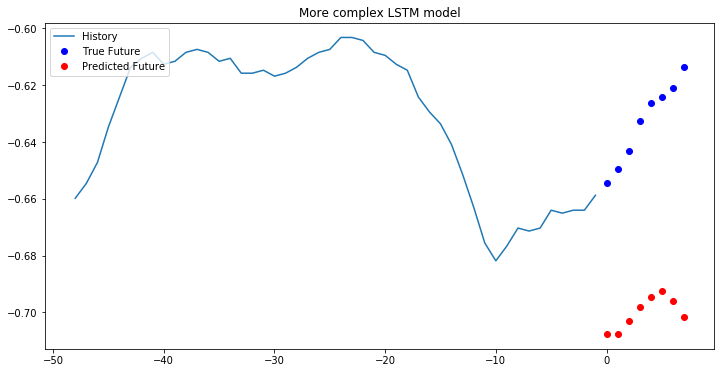

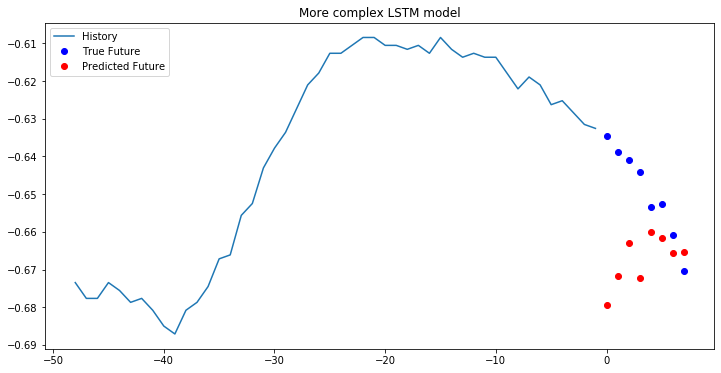

In [60]:
history = 48
future = 8

x_train, y_train = data_windows(ndata, 0, train_split, history, future, single_step=False)
x_validate, y_validate = data_windows(ndata, train_split, None, history, future, single_step=False)

print ('Sample window {}'.format(x_train[0]))
print ('Target level values {}'.format(y_train[0]))

def show_multiple_plot(history, true_future, prediction, title):
  plt.figure(figsize=(12, 6))
  num_in = list(range(-len(history), 0))
  num_out = len(true_future)

  plt.title(title)
  plt.plot(num_in, np.array(history), label='History')
  plt.plot(np.arange(num_out), np.array(true_future), 'bo',
           label='True Future')
  if prediction.any():
    plt.plot(np.arange(num_out), np.array(prediction), 'ro',
             label='Predicted Future')
  plt.legend(loc='upper left')
  plt.show()
    
show_multiple_plot(x_train[0], y_train[0], np.empty([0]), 'Multiple step window sample example')

train = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train = train.cache().shuffle(buffer_size).batch(batch_size).repeat()

validate = tf.data.Dataset.from_tensor_slices((x_validate, y_validate))
validate = validate.batch(batch_size).repeat()

multi_step_model = tf.keras.models.Sequential()
multi_step_model.add(tf.keras.layers.LSTM(32,
                                          return_sequences=True,
                                          input_shape=x_train.shape[-2:]))
multi_step_model.add(tf.keras.layers.LSTM(16, activation='relu'))
multi_step_model.add(tf.keras.layers.Dense(future))

multi_step_model.compile(optimizer=tf.keras.optimizers.RMSprop(clipvalue=1.0), loss='mae')

multi_step_history = multi_step_model.fit(train, epochs=10,
                                          steps_per_epoch=200,
                                          validation_data=validate,
                                          validation_steps=50)

for x, y in validate.take(3):
  show_multiple_plot(x[0], y[0], multi_step_model.predict(x)[0], 'More complex LSTM model')